In [1]:
import splat
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib as mpl
from astropy.visualization import ZScaleInterval
import matplotlib
import wisps
%matplotlib inline

In [2]:
#df_ids=wisps.UCD_SPECTRA.grism_id
df_ids=pd.read_pickle(wisps.LIBRARIES+'/candidates_ids.pkl')[0]

In [3]:
df=pd.DataFrame()

In [4]:
df['grism_id']=df_ids.apply(lambda x: x.replace('g141', 'G141')).values

In [5]:
from dask.distributed import Client, progress
client = Client(processes=False, threads_per_worker=4,
                n_workers=1, memory_limit='2GB',  silence_logs='error')
client

Client Scheduler: inproc://192.168.0.2/4088/1 Dashboard: http://192.168.0.2:8787/status,Cluster Workers: 1 Cores: 4 Memory: 2.00 GB


In [6]:
res=wisps.get_multiple_sources(df.grism_id, source_type='source')

yikes .....  goodsn-41-G141_00942
yikes .....  uds-21-G141_14877
yikes .....  uds-05-G141_41125
yikes .....  uds-25-G141_36758
yikes .....  uds-01-G141_29272
yikes .....  uds-19-G141_32382
yikes .....  uds-15-G141_14762
yikes .....  uds-14-G141_11264
yikes .....  goodsn-36-G141_22694
yikes .....  goodsn-46-G141_19334
yikes .....  goodsn-43-G141_04640
yikes .....  goodsn-43-G141_05553
yikes .....  goodsn-43-G141_05338
yikes .....  goodsn-24-G141_21829
yikes .....  uds-24-G141_32644
yikes .....  uds-14-G141_05410
yikes .....  goodsn-31-G141_01429
yikes .....  uds-10-G141_10211
yikes .....  goodsn-33-G141_09283
yikes .....  uds-07-G141_19719
yikes .....  goodsn-15-G141_29162
yikes .....  goodsn-13-G141_20147
yikes .....  goodsn-22-G141_10686
yikes .....  goodsn-11-G141_11878
yikes .....  goodsn-11-G141_10603
yikes .....  uds-26-G141_34302
yikes .....  goodsn-31-G141_04491
yikes .....  goodsn-32-G141_05180
yikes .....  uds-23-G141_31620
yikes .....  uds-23-G141_32939
yikes .....  uds-09-G1

In [7]:
df['spectra']=res

In [8]:
#remove extra problematic spectra
problems=['cosmos-02-g141_04153', 'cosmos-05-g141_07469']

In [9]:
df=(df[ ~df.grism_id.str.lower().isin(problems)]).reset_index(drop=True)

In [10]:
df['spt']=df['spectra'].apply(lambda x: wisps.make_spt_number(x.spectral_type[0]))

AttributeError: 'NoneType' object has no attribute 'spectral_type'

In [ ]:
df['spt_unc']=df['spectra'].apply(lambda x: wisps.make_spt_number(x.spectral_type[1]))

In [ ]:
df=df.sort_values(by='spt').reset_index(drop=True)

In [ ]:
s=df.spectra.values[0]

In [ ]:
df['distance']=df.spectra.apply(lambda x: x.distance['val'].value)

In [ ]:
df['RA']=df.spectra.apply(lambda x: x.coords.ra.value)
df['DEC']=df.spectra.apply(lambda x: x.coords.dec.value)

In [ ]:
df['snr1']=df.spectra.apply(lambda x: x.snr['snr1'])

In [ ]:
fdf=df[(df.spt >=17.) ]

In [ ]:
len(fdf)

In [ ]:
#distance distributions
from astropy.coordinates import SkyCoord
import astropy.coordinates as astrocoord
import astropy.units as u
coords=SkyCoord(ra=fdf.RA.values*u.deg, dec=fdf.DEC.values*u.deg, distance=fdf.distance.values*u.pc)

In [ ]:
galoc=coords.transform_to(astrocoord.Galactocentric(galcen_distance=8.3*u.kpc))

In [ ]:
#Rsun=8300.
#Zsun=27.
#r=np.sqrt( (coords.distance.value * np.cos( coords.galactic.b.radian ) )**2 + Rsun * (Rsun - 2 * coords.distance.value * np.cos( coords.galactic.b.radian ) * np.cos( coords.galactic.l.radian ) ) )
#z=Zsun+ coords.distance.value * np.sin( coords.galactic.b.radian - np.arctan( Zsun / Rsun) )
x, y, z=galoc.cartesian.xyz
r=(x**2+y**2)**0.5

In [ ]:
fig, (ax, ax1)=plt.subplots(figsize=(11, 4), ncols=2)
sc=ax.scatter(r, z, c=fdf.spt.values, s=50, cmap='viridis',  marker='*')
br=plt.colorbar(sc)
#ax.ylabel('z (pc)', fontsize=20)
#ax.xlabel('r (pc)', fontsize=20)
#plt.grid()

ax.minorticks_on()

sc=ax1.scatter(coords.cartesian.x.value, coords.cartesian.y.value, c=fdf.spt.values, s=50, cmap='viridis', marker='*')


#plt.grid()
ax.minorticks_on()

#ax.set_xlim([6000, 11000])
#ax.set_ylim([-5000, 6000])

#ax1.set_xlim([-11000, -5000])
#ax1.set_ylim([-3000, 3000])

ax.set_ylabel('Z (pc)', fontsize=20)
ax.set_xlabel('R (pc)', fontsize=20)
ax1.set_ylabel('X (pc)', fontsize=20)
ax1.set_xlabel('Y (pc)', fontsize=20)

ax.minorticks_on()
ax1.minorticks_on()


br.set_ticks([20, 25, 30, 35, 40])
br.set_ticklabels(['L0', 'L5', 'T0', 'T5', 'Y0'])
plt.tight_layout()
plt.savefig(wisps.OUTPUT_FIGURES+'/candidate_distances.pdf', bbox_inches='tight')

In [ ]:
mags=wisps.Annotator.reformat_table(pd.DataFrame.from_records(fdf.spectra.apply(lambda x: x.mags).values))

In [ ]:
#MAKE THIS COLOR ABSOLUTE MAG from your mag relations

In [ ]:
abs_mag_relation_140=wisps.POLYNOMIAL_RELATIONS['sp_F140W']
abs_mag_relation_110=wisps.POLYNOMIAL_RELATIONS['sp_F110W']
abs_mag_relation_160=wisps.POLYNOMIAL_RELATIONS['sp_F160W']

In [ ]:
dhgjk=fdf.sort_values(by='distance')[['grism_id', 'distance', 'spt']]

In [ ]:
latc_df=pd.DataFrame()

In [ ]:
latc_df['Shortname']=fdf.spectra.apply(lambda x: x.shortname.upper())
latc_df['designation']=fdf.spectra.apply(lambda x: x.designation.upper())
latc_df['grism id']=fdf.spectra.apply(lambda x: x.name.upper())
latc_df['snrj']=fdf.spectra.apply(lambda x: int(round(x.snr['snr1'])))
latc_df['spt']=fdf.spectra.apply(lambda x: splat.typeToNum(x.spectral_type[0]) +r'$\pm$'+ str(x.spectral_type[1]))
latc_df['ra']=fdf.spectra.apply(lambda x: x.ra.value)
latc_df['dec']=fdf.spectra.apply(lambda x: x.dec.value)
latc_df['f110']=fdf.spectra.apply(lambda x:  str(round(x.mags['F110W'][0],3)) +r'$\pm$'+ str(round(x.mags['F110W'][1],3)))
#latc_df['f110_er']=fdf.spectra.apply(lambda x: round(x.mags['F110W'][1], 1))
latc_df['f140']=fdf.spectra.apply(lambda x:  str(round(x.mags['F140W'][0],3)) +r'$\pm$'+  str(round(x.mags['F140W'][1],3)))
#latc_df['f140_er']=fdf.spectra.apply(lambda x: round(x.mags['F140W'][1], 1))
latc_df['f160']=fdf.spectra.apply(lambda x:   str(round(x.mags['F160W'][0],3)) + r'$\pm$'+ str(round(x.mags['F160W'][1],3)))
#latc_df['f160_er']=fdf.spectra.apply(lambda x: round(x.mags['F160W'][1], 1))
latc_df['distance']=fdf.spectra.apply(lambda x: str(int(round(x.distance['val'].value, 0)))  + r'$\pm$'+ 
                                                 str((int(round(x.distance['er'].value, 0)))))

In [ ]:
latc_df=latc_df.replace('nan$\\pm$nan', 'nodata')

In [ ]:
#get the right sequence of coplumns

col_list=['designation','grism id', 'ra', 'dec', 'f110', 'f140', 'f160', 'snrj', 'spt', 'distance']

In [ ]:
latc_df[col_list]

In [ ]:
latc_df[col_list].to_latex(wisps.LIBRARIES+'/candidates.tex',
             header=True, index=False, na_rep=' ')

In [ ]:
for k in (fdf.spectra.iloc[0]).mags.keys():
    fdf[k]=fdf.spectra.apply(lambda x: x.mags[k])
    
for k in (fdf.spectra.iloc[0]).indices.keys():
    fdf[k]=fdf.spectra.apply(lambda x: x.indices[k])
    

In [ ]:
fdf.columns

In [ ]:
fdf.to_pickle(wisps.LIBRARIES+'/candidates.pkl')

In [ ]:
#%%capture
fold='/Users/caganze/research/wisps/figures/ltwarfs/'

ids=0
for idx, row in fdf.iterrows():
    try:
        s=row.spectra
        print (s)
        filename=fold+'spectrum'+str(ids)+'.jpeg'
        s.plot(save=True, filename=filename)
        ids=ids+1
    except:
        s=wisps.Source(filename=row.grism_id.replace('g141', 'G141'),is_ucd=False )
        print (s)
        filename=fold+'spectrum'+str(ids)+'.jpeg'
        s.plot(save=True, filename=filename)
        ids=ids+1


In [ ]:
from astropy.coordinates import SkyCoord

In [ ]:
#indices_df=pd.DataFrame.from_records(df.spectra.apply(lambda x: x.indices).values)

In [ ]:
#for k in indices_df.columns: df[k]= indices_df[k]

In [ ]:
#df.to_hdf(wisps.OUTPUT_FILES+'/true_spectra_cands.hdf', key='with_indices')

In [ ]:
import astropy.units as u

In [ ]:
sk=SkyCoord(ra=fdf.RA.values*u.deg, dec=fdf.DEC.values*u.deg, distance=fdf.distance.values*u.pc)

In [ ]:
norm = matplotlib.colors.Normalize(vmin=20., vmax=37.0)

In [ ]:
from matplotlib import cm

In [ ]:
import wisps.simulations as wispsim

In [ ]:
df['pointing']=df.grism_id.apply(wispsim.get_proper_pointing)

In [ ]:
pntcoords=SkyCoord([x.coord for x in wisps.OBSERVED_POINTINGS if not x.name in df.pointing.values])

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='mollweide')

ax.scatter(pntcoords.galactic.l.wrap_at(180*u.deg).radian, pntcoords.galactic.b.wrap_at(180*u.deg).radian, c='grey', marker='x', alpha=0.5)
c=ax.scatter(sk.galactic.l.wrap_at(180*u.deg).radian, sk.galactic.b.wrap_at(180*u.deg).radian,
           c=np.vstack(fdf.spt.values)[:,0], cmap='viridis')


plt.xlabel("l", fontsize=18)
plt.ylabel("b", fontsize=18)
plt.grid()
plt.minorticks_on()
plt.tight_layout()
plt.savefig(wisps.OUTPUT_FIGURES+'/candidate_skymap.pdf', bbox_inches='tight')

In [ ]:
def plot_vals(values, ax, title):
    values=wisps.drop_nan(np.sort(values))
    kernel = stats.gaussian_kde(values)
    height = kernel.pdf(values)
    mode_value = values[np.argmax(height)]
    h=ax.hist(values, bins='auto', normed=True, histtype='step')
    ax.plot(values, height)
    ax.axvline(mode_value, c='k')
    ax.set_xlabel(title, fontsize=18)

In [ ]:
#fig, ax=plt.subplots(ncols=3,figsize=(12, 4))
#plot_vals((wisps.OBSERVED_POINTINGS[np.random.randint(533)]).mags['F110'], ax[0], 'F110W')
#plot_vals((wisps.OBSERVED_POINTINGS[np.random.randint(533)]).mags['F140'], ax[1], 'F140W')
#plot_vals((wisps.OBSERVED_POINTINGS[np.random.randint(533)]).mags['F160'], ax[2], 'F160W')
#plt.tight_layout()
#plt.savefig(wisps.OUTPUT_FIGURES+'/mag_limits_illustration.pdf', bbox_inches='tight')

In [ ]:
df['designation']=df.spectra.apply(lambda x: x.designation)

In [ ]:
df.shape

In [ ]:
df.to_pickle(wisps.OUTPUT_FILES+'/true_spectra_cands.pkl')

In [ ]:
dfn=df[df.spt>=17]

In [ ]:
import seaborn as sns

In [ ]:
fig, ax=plt.subplots()

sns.distplot(fdf.spt,  ax=ax, hist_kws={'log': True},  norm_hist=False, kde=False)
#h=ax.hist(dfn.spt, log=True, bins=38-17)
#dfn['spt'].plot(kind='hist')

ax.set_xticks([17, 20, 25, 30, 35, 40])
ax.set_xticklabels(['M7', 'L0', 'L5', 'T0', 'T5', 'Y0'])

ax.set_xlabel('Spectral Type', fontsize=18)
ax.set_ylabel('Number', fontsize=18)

plt.minorticks_on()
plt.tight_layout()
plt.savefig(wisps.OUTPUT_FIGURES+'/sptdistribution.pdf')

In [ ]:
fig, ax=plt.subplots()

sns.distplot(fdf.distance.apply(np.log10),  ax=ax, hist_kws={'log': True}, norm_hist=False, kde=False)
#h=ax.hist(dfn.spt, log=True, bins=38-17)
#dfn['spt'].plot(kind='hist')

#ax.set_xticks([17, 20, 25, 30, 35, 40])
#ax.set_xticklabels(['M7', 'L0', 'L5', 'T0', 'T5', 'Y0'])

ax.set_xlabel('Log Distance (pc)', fontsize=18)
ax.set_ylabel('Number', fontsize=18)

plt.minorticks_on()
plt.tight_layout()
plt.savefig(wisps.OUTPUT_FIGURES+'/distdistribution.pdf')

In [ ]:
s=fdf.spectra.iloc[-1]

In [ ]:
%%capture 
res=splat.classifyByTemplate(s.splat_spectrum, range=[[1.15, 1.65]], spt=[34,38], force=True )

#########################

In [1]:
import wisps.simulations as wispsim
import splat
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib as mpl
from astropy.visualization import ZScaleInterval
import matplotlib
import wisps

%matplotlib inline

In [186]:
def format_jk_zhang(row):
    jmag=np.nan
    hmag=np.nan
    jmag_er=np.nan
    hmag_er=np.nan
    if row['J'] !='none':
        #print ((row['J']).split('±'))
        #row['J_mag']=(row['J']).split('±')[0]
        #row['J_er']=(row['J']).split('±')[-1]
        jmag=(row['J']).split('±')[0]
        jmag_er=(row['J']).split('±')[1]
        
    if row['H'] !='none':
        #print ((row['H']).split('±'))
        #row['H_mag']=(row['H']).split('±')[0]
        #row['H_er']=(row['H']).split('±')[-1]
        hmag=(row['H']).split('±')[0]
        hmag_er=(row['H']).split('±')[1]
        
    spt=splat.typeToNum(row[' SpT'])
        
    return pd.Series({'H':jmag, 'J':hmag, 'H_er':hmag_er, 'J_er':jmag_er, 'SpTn':spt})

def format_jk_manj(row):
    jmag=np.nan
    hmag=np.nan
    jmag_er=np.nan
    hmag_er=np.nan
    if str(row['J (mag)']) !='nan':
        #ignore others
        if not str(row['J (mag)']).startswith('>'):
            jmag=((row['J (mag)']).split('+or-')[0]).strip()
            jmag_er=((row['J (mag)']).split('+or-')[1]).strip()

    if str(row['H (mag)']) !='nan':
        if not str(row['J (mag)']).startswith('>'):
            hmag=(row['H (mag)']).split('+or-')[0]
            hmag_er=(row['H (mag)']).split('+or-')[1]
        
    spt=splat.typeToNum(row['SpT'])
        
    return pd.Series({'H':jmag, 'J':hmag, 'H_er':hmag_er, 'J_er':jmag_er, 'SpTn':spt})

In [3]:
fdf=pd.read_pickle(wisps.LIBRARIES+'/candidates.pkl')

In [170]:
fdf=wisps.Annotator.reformat_table(fdf)
spts0ssss=np.vstack(fdf.spt.values)[:,0]

In [171]:
pols=wisps.POLYNOMIAL_RELATIONS

In [172]:
color_pol=pols['colors']

In [173]:
#splat 
spdf=splat.searchLibrary()
spdf['SHORTNAME']=spdf.DESIGNATION.apply(lambda x: splat.designationToShortName)
spdwarf=spdf[~ (spdf.PARALLAX.isna() | spdf.SHORTNAME.isin(wisps.FORBIDDEN_LIST) 
               |(spdf.METALLICITY_CLASS=='sd') | (spdf.METALLICITY_CLASS=='d/sd'))]
spsubdwarf=spdf[(spdf.METALLICITY_CLASS=='sd') ]
spdwarf['SPEX_TYPE']=spdwarf['SPEX_TYPE'].apply(wisps.make_spt_number)
spsubdwarf['SPEX_TYPE']=spsubdwarf['SPEX_TYPE'].apply(wisps.make_spt_number)

In [174]:
#zhang
zhng=pd.read_csv('~/research/wisps/data/zhang_data.csv')
zhng_clrs=zhng.apply(format_jk_zhang, axis=1 ).applymap(float)

In [187]:
#manjavacas
man_df0=pd.read_csv('/users/caganze/research/wisps/data/manjavaca_phot.txt', sep='\t',  index_col=None)
man_clrs=man_df0.apply(format_jk_manj, axis=1 ).applymap(float)

In [199]:
fdf['J']=fdf['F140W']+color_pol['j_f140'][0](fdf['spt'])
fdf['J_er']=(fdf['F140W_er']**2+color_pol['j_f140'][1]**2)**0.5

fdf['H']=fdf['F160W']+color_pol['h_f160'][0](fdf['spt'])
fdf['H_er']=(fdf['F160W_er']**2+color_pol['h_f160'][1]**2)**0.5

In [219]:
zhng_clrs.columns

Index(['H', 'J', 'H_er', 'J_er', 'SpTn'], dtype='object')

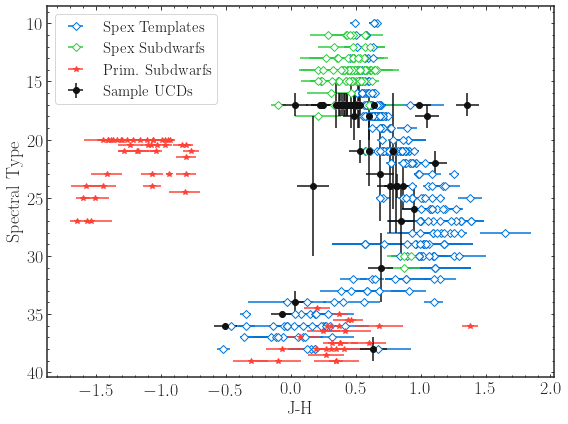

In [242]:
fig, ax=plt.subplots(figsize=(8, 6))



ax.errorbar(spdwarf['J_2MASS']-spdwarf['H_2MASS'], spdwarf.SPEX_TYPE, fmt='D', 
            xerr=(spdwarf.J_2MASS_E**2+spdwarf.H_2MASS_E**2)**0.5, color='#0074D9', mfc='white', label='Spex Templates')

ax.errorbar(spsubdwarf['J_2MASS']-spsubdwarf['H_2MASS'],spsubdwarf.SPEX_TYPE, fmt='D', 
            xerr=(spsubdwarf.J_2MASS_E**2+spsubdwarf.H_2MASS_E**2)**0.5, color='#2ECC40', mfc='white', label='Spex Subdwarfs')


ax.errorbar(zhng_clrs['J']-zhng_clrs['H'],zhng_clrs.SpTn, fmt='*', 
            xerr=(zhng_clrs.J_er**2+zhng_clrs.H_er**2)**0.5, color='#FF4136', label='Prim. Subdwarfs')



ax.errorbar(fdf['J']-fdf['H'], fdf['spt'], fmt='o', xerr=(fdf['J_er']**2+fdf['H_er']**2)**0.5, 
            yerr=fdf['spt_unc'], color='#111111', label='Sample UCDs')

ax.invert_yaxis()

ax.minorticks_on()
ax.set_ylabel('Spectral Type', fontsize=18)
ax.set_xlabel('J-H', fontsize=18)

ax.legend(loc='upper left', fontsize=15)

plt.tight_layout()
#plt.grid()

plt.savefig(wisps.OUTPUT_FIGURES+'/color_color_plots.pdf')
